In [1]:
%matplotlib inline

## CG-Invariances over Images
In this example, we wish to find the bases for the $3 \times 3$ kernel that acts over an RGB image patch. <br>
We are given 3 groups:  <br>
<ol>
    <li> $\mathcal{G}_\text{rot}$ rotates the image patch by 90 degree multiples.
    <li> $\mathcal{G}_\text{col}$ permutes the color channels.
    <li> $\mathcal{G}_\text{vflip}$ vertically flips the image patch.

## Lemma 2 : Find the left 1-eigenspace of $\bar{T}$ for each of the 3 given groups

Each image shows 2 left eigenvectors of $\bar{T}$, the Reynolds operator of the respective group. Note that each eigenvector is in $\mathbb{R}^{27}$ (3 channels of size $3 \times 3$). The channels are stacked horizontally for visualization and separated by dashed boxes. <br>
The eigenvectors are invariant to the respective groups; for instance, the first eigenvector in the top image is invariant to all rotations of 90 degree multiples.

Invariant Subspace of G_rotation: 2 example basis


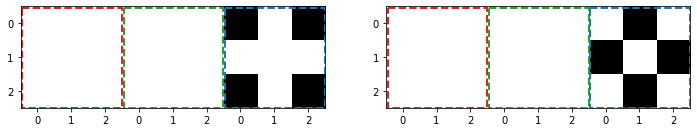

Invariant Subspace of G_color_permutation: 2 example basis


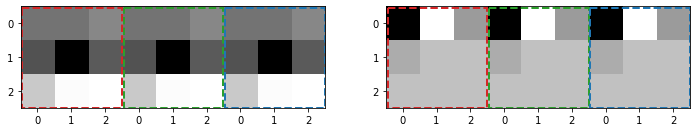

Invariant Subspace of G_verticalFlip: 2 example basis


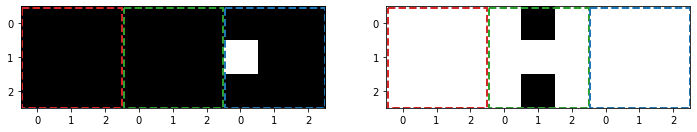

In [2]:
import numpy as np
import itertools
from functools import partial
from invariantSubspaces import G_permutation, G_rotation, G_color_permutation, G_verticalFlip, getInvariantSubspace, showSubspace

inputChannels = 3
kernelSize = (3, 3)
Wshape = (3, *kernelSize)
Wsize = np.prod(Wshape)
groups = [G_rotation, G_color_permutation, G_verticalFlip]

listV = []
for g in groups:
    V, Vc, S = getInvariantSubspace(Wshape, g, method="onehot")
    listV.append(V)
    
# print(f"Example basis for the invariant subspaces. The RGB channels are stacked horizontally.")
nBasisShow = 2
for g, V in zip(groups, listV):
    print(f"Invariant Subspace of {g.__name__}: {nBasisShow} example basis")
    showSubspace(V, Wshape, ndim=nBasisShow, channels=True)

## Theorem 3 : Find bases for entire $W$ space in partial order of decreasing invariance 
Given $i=0,1,2$, the left eigenspace $\mathcal{W}_i$ of the Reynolds operator of the group $\mathcal{G}_i$, we need to find a basis corresponding the each subset of $\{\mathcal{G}_\text{rot}, \mathcal{G}_\text{col}, \mathcal{G}_\text{vflip}\}$ such that the weights in the corresponding weight space are:
<ul>
    <li> Invariant to the chosen subset.
    <li> <b> Not invariant </b> to any group not in the subset.
</ul>

The figure below shows the partial order over these subsets ranging from maximum invariance at the top and no invariance at the bottom. Theorem 3 finds these bases from top to bottom as follows.
Assume for example that we wish to find the basis for the subset $\{\mathcal{G}_\text{rot}, \mathcal{G}_\text{vflip}\}$. Recall that the corresponding space should not be invariant to $\mathcal{G}_\text{col}$. 
<ol>
<li> First, we find the intersection $\tilde{\mathcal{B}}_{\{\text{rot}, \text{vflip}\}} = \mathcal{W}_\text{rot} \cap \mathcal{W}_\text{vflip}$
<li> Then, we remove the orthogonal projections on every basis found on the path to the root. In the current example,
    $$
      {\mathcal{B}}_{\{\text{rot}, \text{vflip}\}}  = \tilde{\mathcal{B}}_{\{\text{rot}, \text{vflip}\}} - \text{proj}_{{\mathcal{B}}_{\{\text{rot}, \text{col},\text{vflip}\}}}\left(\tilde{\mathcal{B}}_{\{\text{rot}, \text{vflip}\}}\right)
    $$
<br>
Continuing as above from top to bottom, all the bases can be found. All the bases together cover the entire $\mathbb{R}^{27}$ space.
<img src="figs/hasse.png">
<br>
The code below implements Theorem 3 and shows 2 example basis vectors for all the subsets. Notably there is no basis when invariance to $\mathcal{G}_\text{rot}$ and sensitivity to $\mathcal{G}_\text{vflip}$ is required. <br>
As an example, we can see that the subspace of $\{\mathcal{G}_\text{rotation}, \mathcal{G}_\text{vflip}\}$ is invariant to rotations and vertical flips but not RGB channel permutations.

Finding subspace of  ['G_rotation', 'G_color_permutation', 'G_verticalFlip']
Finding subspace of  ['G_rotation', 'G_color_permutation']
Finding subspace of  ['G_rotation', 'G_verticalFlip']
Finding subspace of  ['G_color_permutation', 'G_verticalFlip']
Finding subspace of  ['G_rotation']
Finding subspace of  ['G_color_permutation']
Finding subspace of  ['G_verticalFlip']
Finding subspace of  []
Subspace of  ['G_rotation', 'G_color_permutation', 'G_verticalFlip']


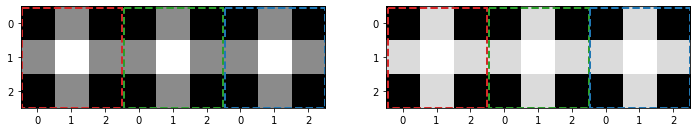

Subspace of  ['G_rotation', 'G_verticalFlip']


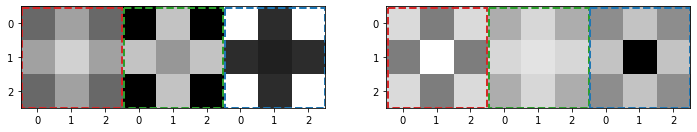

Subspace of  ['G_color_permutation', 'G_verticalFlip']


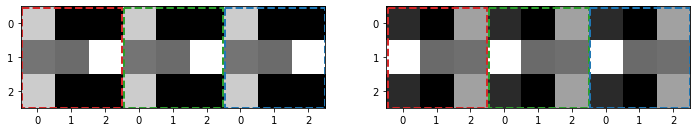

Subspace of  ['G_color_permutation']


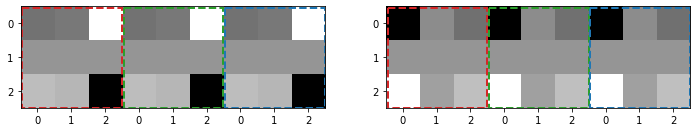

Subspace of  ['G_verticalFlip']


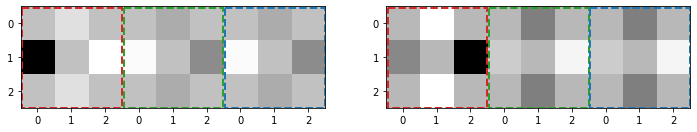

Subspace of  []


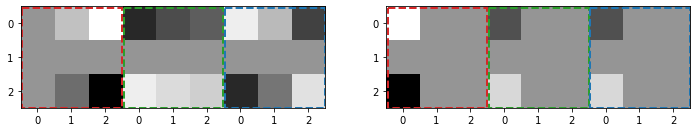

In [3]:
from invariantSubspaces import findAllSubspaces, indexPowerSetTranspositions
listT = groups
powerSetMethod = None
powerSet, powerSetConfigs = findAllSubspaces(listV=listV, listT=listT, powerSetMethod=powerSetMethod)
for subspace, config in zip(powerSet, powerSetConfigs):
    print("Subspace of ", [listT[i].__name__ for i in config])
    showSubspace(subspace, Wshape, 2, channels=True)

## The kernel $\mathbf{w}$ and the associated penalty
Now that we have identified the basis for each subspace, we can any represent weight $3 \times 3 \times 3$ RGB kernel as a linear combination of these basis vectors. Let $\mathcal{B} = [\mathcal{B}_{\{rot, col, vflip\}} ~~\mathcal{B}_{\{rot, col\}} \cdots ~~\mathcal{B}_\emptyset]$ be the matrix with the bases stacked as column vectors and $\omega \in \mathbb{R}^{27}$ be the corresponding learnable parameters, then we compute the weight kernel as $\mathbf{w} = \mathcal{B} \omega$. <br>

Interestingly, the invariance of the kernel $\mathbf{w}$ depends on which of the bases have the corresponding parameters in $\omega$ as non-zero. Now since we want maximal invariance without affecting the task loss, we use the following penalty (see figure below):
<ol>
    <li> Find the least invariant bases with the corresponding parameters non-zero (in the figure, lowest level with a green cell).
    <li> Add one to the penalty for each basis at higher levels. 
    <li> Add one to the penalty for each basis with corresponding parameters non-zero in the current level.
</ol>

The penalty is higher when lower levels (with less invariant bases) are used. We use a differentiable approximation of this penalty. 
<img src="figs/myhassepenalty.png">

## CG-CNN architecture composed of multiple layers
Image below depicts an example CG-invariant CNN architecture with 2 convolutional layers. For each convolutional layers, the kernel weights are obtained as above using the basis of the subspaces (as usual, there is a kernel corresponding to each output channel). Only the first convolutional layer includes the group $\mathcal{G}_\text{col}$. The last layer before dense layers is a Sum-pool layer over the entire feature map; this ensures that the invariance over the entire image is considered (and not just over the patches). 
<br>
The total penalty is the sum of penalties over all convolutional layers. 
<img src="figs/cgcnn.png">